## **2. Portfolio construction**

- This notebook uses the processed historical dataset (`asset_universe.csv`) as the starting point.
- The goal is to compute daily log-returns per asset, build a preliminary portfolio return series, define initial weights and derive first-order KPIs.
- **Logarithmic returns** are used for **statistical validation**, as they are time-additive and mathematically more stable under compounding for distribution analysis.
- **Arithmetic (simple) returns** are used for **portfolio and capital evolution**, since they correctly replicate real investment performance over time (e.g. equity curve, drawdown, compounding).
- Cross-sectional **z-scores** (based on mean and standard deviation) are applied to compare assets and highlight unusual behaviour; robust alternatives (e.g. median/MAD) are left as a potential refinement.

**RESULTS**  
- Most assets exhibit stable statistical behaviour
- A small subset — for example Brent Crude Oil (`BZ`), WTI Crude Oil (`CL`), FTSE 100 (`FTSE`) and S&P 500 (`GSPC`) — shows heavier tails (`kurt > 10`), asymmetric returns (`|z_skew| > 2`), atypical average returns (`|z_mean| > 2`) and/or elevated volatility (`|z_std| > 2`), and will be monitored more closely in the risk-focused stages of the project.

#### **2.1 Importing necessary libraries**

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from src.helpers_io import read_csv_processed

#### **2.2 Loading `asset_universe.csv`**

In [2]:
asset_universe = read_csv_processed("asset_universe.csv", parse_dates=["Date"]).set_index("Date").sort_index()
asset_universe

,AMZN,BZ,CL,EURUSD,FTSE,GBPUSD,GC,GSPC,IEF,IXIC,JPM,MSFT,NG,NVDA,ORCL,SI,TLT,USDJPY
Date,,,,,,,,,,,,,,,,,,
2019-01-02,76.956497,54.910000,46.540001,1.146171,6734.200195,1.275429,1281.000000,2510.030029,89.408447,6665.939941,81.616714,94.612610,2.958,3.377354,40.754520,15.542000,101.310341,109.667999
2019-01-03,75.014000,55.950001,47.090000,1.131811,6692.700195,1.252191,1291.800049,2447.889893,90.119125,6463.500000,80.456787,91.132011,2.945,3.173305,40.357971,15.706000,102.463249,107.441002
2019-01-04,78.769501,57.060001,47.959999,1.139108,6837.399902,1.262881,1282.699951,2531.939941,89.391357,6738.859863,83.422867,95.370491,3.044,3.376611,42.097378,15.695000,101.277229,107.807999
2019-01-07,81.475502,57.330002,48.520000,1.141044,6810.899902,1.273496,1286.800049,2549.689941,89.143028,6823.470215,83.480865,95.492126,2.944,3.555370,42.764309,15.669000,100.978592,108.522003
2019-01-08,82.829002,58.720001,49.779999,1.147974,6861.600098,1.278609,1283.199951,2574.409912,88.920418,6897.000000,83.323448,96.184494,2.967,3.466858,43.151836,15.626000,100.713196,108.615997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-20,224.919998,72.940002,69.459999,1.036495,8084.600098,1.249797,2628.699951,5930.850098,89.719093,19572.599609,232.674530,433.402924,3.748,134.670654,167.989136,29.660000,85.179314,157.643997
2024-12-23,225.059998,72.629997,69.239998,1.043308,8102.700195,1.256992,2612.300049,5974.069824,89.321884,19764.880859,233.448151,432.062744,3.656,139.639572,167.474243,29.888000,84.398026,156.533005
2024-12-24,229.050003,73.580002,70.099998,1.040583,8137.000000,1.253447,2620.000000,6040.040039,89.370331,20031.130859,237.286896,436.112854,3.946,140.189468,169.721893,29.974001,84.754929,157.164993


#### **2.3 Calculating log returns per asset**

Daily returns are computed using the logarithmic formula:

$$
r_t = \ln\left(\frac{P_t}{P_{t-1}}\right)
$$

Log returns are preferred in quantitative finance because they are time-additive and provide better statistical stability under compounding

In [3]:
# Computing log returns
log_returns_raw = pd.DataFrame(np.log(asset_universe / asset_universe.shift(1)))
log_returns_raw

c:\Users\james\Desktop\UK Life\Data Scientist Career Path\My notes (Python, SQL, etc.)\Portfolio of projects\finance-project\env\Lib\site-packages\pandas\core\internals\blocks.py:395: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


,AMZN,BZ,CL,EURUSD,FTSE,GBPUSD,GC,GSPC,IEF,IXIC,JPM,MSFT,NG,NVDA,ORCL,SI,TLT,USDJPY
Date,,,,,,,,,,,,,,,,,,
2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,-0.025566,0.018763,0.011748,-0.012608,-0.006182,-0.018387,0.008396,-0.025068,0.007917,-0.030840,-0.014314,-0.037482,-0.004405,-0.062319,-0.009778,0.010497,0.011316,-0.020516
2019-01-04,0.048851,0.019645,0.018307,0.006427,0.021390,0.008501,-0.007069,0.033759,-0.008108,0.041720,0.036202,0.045460,0.033064,0.062099,0.042197,-0.000701,-0.011643,0.003410
2019-01-07,0.033777,0.004721,0.011609,0.001699,-0.003883,0.008370,0.003191,0.006986,-0.002782,0.012477,0.000695,0.001275,-0.033403,0.051587,0.015718,-0.001658,-0.002953,0.006601
2019-01-08,0.016476,0.023956,0.025637,0.006054,0.007416,0.004007,-0.002802,0.009649,-0.002500,0.010718,-0.001887,0.007224,0.007782,-0.025210,0.009021,-0.002748,-0.002632,0.000866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-20,0.007273,0.000823,-0.006458,0.001419,-0.002557,-0.005565,0.013982,0.010810,0.003678,0.010262,0.019722,-0.000984,0.044743,0.030299,0.005141,0.019267,0.005678,0.019026
2024-12-23,0.000622,-0.004259,-0.003172,0.006551,0.002236,0.005741,-0.006258,0.007261,-0.004437,0.009776,0.003319,-0.003097,-0.024853,0.036232,-0.003070,0.007658,-0.009215,-0.007072
2024-12-24,0.017573,0.012995,0.012344,-0.002615,0.004224,-0.002824,0.002943,0.010982,0.000542,0.013381,0.016310,0.009330,0.076333,0.003930,0.013332,0.002873,0.004220,0.004029


#### **2.4 Checking NaNs and anomalies**

- Missing values are inspected to identify whether they result from shift operations or exceptional market events.
- On **20 April 2020**, WTI Crude Oil (`CL`) traded at unprecedented negative prices due to the COVID-19 demand collapse and storage constraints.  
- This was a **highly unusual stress event** and will be considered separately in future risk or scenario analysis.

In [4]:
# Verifying where NaN values come from
display(log_returns_raw[log_returns_raw.isna().any(axis=1)])

# Identifying what dates these NaN values occurred
display(asset_universe.loc["2020-04-20":"2020-04-21", "CL"])    # Historic event

,AMZN,BZ,CL,EURUSD,FTSE,GBPUSD,GC,GSPC,IEF,IXIC,JPM,MSFT,NG,NVDA,ORCL,SI,TLT,USDJPY
Date,,,,,,,,,,,,,,,,,,
2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-20,0.007805,-0.093638,NaN,0.000782,0.004448,-0.000025,0.007314,-0.018043,0.002625,-0.01039,-0.037138,-0.020020,0.093078,-0.018193,-0.013084,0.020720,0.008012,-0.002551
2020-04-21,-0.027742,-0.279761,NaN,-0.000196,-0.030001,-0.003590,-0.013847,-0.031155,0.002781,-0.03537,-0.029433,-0.042237,-0.055021,-0.063051,-0.049430,-0.048604,0.012513,-0.000009


Date
2020-04-20   -37.630001
2020-04-21    10.010000
Name: CL, dtype: float64

#### **2.5 Dropping NaNs**

- **All NaN entries** (including the **WTI** stress date) **are removed** to maintain a clean and uniform matrix across all assets.
- This has a negligible impact on the long-term dataset and ensures reliable statistical analysis for portfolio construction.
- Extreme events will be assessed later as standalone scenarios.

In [5]:
# Clean log returns
log_returns = log_returns_raw.dropna()
log_returns

,AMZN,BZ,CL,EURUSD,FTSE,GBPUSD,GC,GSPC,IEF,IXIC,JPM,MSFT,NG,NVDA,ORCL,SI,TLT,USDJPY
Date,,,,,,,,,,,,,,,,,,
2019-01-03,-0.025566,0.018763,0.011748,-0.012608,-0.006182,-0.018387,0.008396,-0.025068,0.007917,-0.030840,-0.014314,-0.037482,-0.004405,-0.062319,-0.009778,0.010497,0.011316,-0.020516
2019-01-04,0.048851,0.019645,0.018307,0.006427,0.021390,0.008501,-0.007069,0.033759,-0.008108,0.041720,0.036202,0.045460,0.033064,0.062099,0.042197,-0.000701,-0.011643,0.003410
2019-01-07,0.033777,0.004721,0.011609,0.001699,-0.003883,0.008370,0.003191,0.006986,-0.002782,0.012477,0.000695,0.001275,-0.033403,0.051587,0.015718,-0.001658,-0.002953,0.006601
2019-01-08,0.016476,0.023956,0.025637,0.006054,0.007416,0.004007,-0.002802,0.009649,-0.002500,0.010718,-0.001887,0.007224,0.007782,-0.025210,0.009021,-0.002748,-0.002632,0.000866
2019-01-09,0.001713,0.045281,0.050530,-0.002064,0.006537,-0.003777,0.004743,0.004090,0.000578,0.008673,-0.001692,0.014198,0.005713,0.019476,-0.002091,0.001726,-0.001566,0.001472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-20,0.007273,0.000823,-0.006458,0.001419,-0.002557,-0.005565,0.013982,0.010810,0.003678,0.010262,0.019722,-0.000984,0.044743,0.030299,0.005141,0.019267,0.005678,0.019026
2024-12-23,0.000622,-0.004259,-0.003172,0.006551,0.002236,0.005741,-0.006258,0.007261,-0.004437,0.009776,0.003319,-0.003097,-0.024853,0.036232,-0.003070,0.007658,-0.009215,-0.007072
2024-12-24,0.017573,0.012995,0.012344,-0.002615,0.004224,-0.002824,0.002943,0.010982,0.000542,0.013381,0.016310,0.009330,0.076333,0.003930,0.013332,0.002873,0.004220,0.004029


In [6]:
# Checking NaNs
log_returns.isna().sum()

AMZN      0
BZ        0
CL        0
EURUSD    0
FTSE      0
GBPUSD    0
GC        0
GSPC      0
IEF       0
IXIC      0
JPM       0
MSFT      0
NG        0
NVDA      0
ORCL      0
SI        0
TLT       0
USDJPY    0
dtype: int64

#### **2.6 Statistical validation of log returns**

Before moving into portfolio construction and risk modelling, I perform a cross-sectional quality check on daily log-returns for all assets in the universe.

To compare assets against each other, several metrics are standardised using cross-sectional z-scores:

- `z_mean`: distance (in standard deviations) between each asset’s mean return and the cross-sectional mean of means.
- `z_std`: distance between each asset’s volatility and the cross-sectional average volatility.
- `z_skew`, `z_kurt`, `z_iqr`: analogous z-scores for skewness, kurtosis and the interquartile range.

From these metrics, I define a set of diagnostic flags:

- `low_variance`: assets in the lowest 5% of the cross-sectional standard-deviation distribution (very low volatility).
- `extreme_volatility`: assets with `|z_std| > 2` (volatility significantly higher or lower than the group).
- `extreme_mean`: assets with `|z_mean| > 2` (unusually high or low average return).
- `tail_risk`: assets with `kurtosis > 10` (very heavy tails and frequent extreme moves).
- `asymmetric_returns`: assets with `|z_skew| > 2` (markedly asymmetric return distribution).
- `flat_distribution`: assets with IQR in the lowest 10% of the cross-sectional distribution (very concentrated returns).

These flags summarise which assets behave “normally” and which warrant closer attention in the subsequent risk analysis phases.

In [7]:
# Calculating stats
stats = log_returns.agg(['mean', 'std', 'min', 'max', 'skew', 'kurtosis']).T

# Quantiles and Interquantile Range (IQR)
quantiles = log_returns.quantile(q=[0, 0.25, 0.50, 0.75, 1]).T
quantiles.columns = ["q0", "q25", "q50", "q75", "q100"]
stats = stats.merge(quantiles, left_index=True, right_index=True)
stats['iqr'] = stats['q75'] - stats['q25']

# Z-scores
stats['z_mean'] = (stats['mean'] - stats['mean'].mean()) / stats['mean'].std()
stats['z_std'] = (stats['std'] - stats['std'].mean()) / stats['std'].std()
stats['z_skew'] = (stats['skew'] - stats['skew'].mean()) / stats['skew'].std()
stats['z_kurt'] = (stats['kurtosis'] - stats['kurtosis'].mean()) / stats['kurtosis'].std()
stats['z_iqr'] = (stats['iqr'] - stats['iqr'].mean()) / stats['iqr'].std()

# Quality flags
stats["low_variance"] = stats["std"] < stats["std"].quantile(0.05)
stats["extreme_volatility"] = abs(stats["z_std"]) > 2
stats["extreme_mean"] = abs(stats["z_mean"]) > 2
stats["tail_risk"] = stats["kurtosis"] > 10
stats["asymmetric_returns"] = abs(stats["z_skew"]) > 2
stats["flat_distribution"] = stats["iqr"] < stats["iqr"].quantile(0.10)

# Functions to highlight atypical stats
def highlight_flags(row):
    flags = [
        'low_variance',
        'extreme_volatility',
        'extreme_mean',
        'tail_risk',
        'asymmetric_returns',
        'flat_distribution'
    ]
    if row[flags].any():
        return ['background-color: #6b1515'] * len(row)
    return [''] * len(row)

def highlight_zscore(val):
    if abs(val) > 2:
        return 'background-color: #74700f'
    return ''

styled_stats = (
    stats
    .style
    .apply(highlight_flags, axis=1)
    .map(highlight_zscore, subset=['z_mean', 'z_std', 'z_skew', 'z_kurt', 'z_iqr'])
)
styled_stats

,mean,std,min,max,skew,kurtosis,q0,q25,q50,q75,q100,iqr,z_mean,z_std,z_skew,z_kurt,z_iqr,low_variance,extreme_volatility,extreme_mean,tail_risk,asymmetric_returns,flat_distribution
AMZN,0.000730,0.021860,-0.151398,0.126949,-0.070206,4.547554,-0.151398,-0.010712,0.000932,0.012064,0.126949,0.022776,0.288193,0.388778,0.361517,-0.651165,0.464027,False,False,False,False,False,False
BZ,0.000459,0.026032,-0.275751,0.190774,-0.724666,14.255899,-0.275751,-0.010812,0.002027,0.013449,0.190774,0.024261,-0.147717,0.765430,-1.178890,0.874030,0.593037,False,False,False,True,False,False
CL,0.000695,0.032283,-0.282206,0.319634,0.039197,24.592480,-0.282206,-0.012833,0.002108,0.015180,0.319634,0.028012,0.231068,1.329866,0.619019,2.497922,0.918854,False,False,False,True,False,False
EURUSD,-0.000064,0.004541,-0.028144,0.018211,-0.141536,2.051878,-0.028144,-0.002664,-0.000042,0.002629,0.018211,0.005293,-0.990726,-1.174995,0.193626,-1.043240,-1.054477,True,False,False,False,False,True
FTSE,0.000144,0.010560,-0.115117,0.086664,-1.161788,16.754249,-0.115117,-0.004293,0.000667,0.005152,0.086664,0.009445,-0.654636,-0.631545,-2.207747,1.266525,-0.693862,False,False,False,True,True,False
GBPUSD,-0.000007,0.005813,-0.042324,0.030308,-0.242224,5.322463,-0.042324,-0.003062,-0.000122,0.003081,0.030308,0.006143,-0.898199,-1.060163,-0.043362,-0.529426,-0.980664,False,False,False,False,False,False
GC,0.000486,0.009883,-0.051069,0.057775,-0.291721,3.807129,-0.051069,-0.004210,0.000622,0.005947,0.057775,0.010157,-0.104341,-0.692678,-0.159863,-0.767487,-0.631969,False,False,False,False,False,False
GSPC,0.000614,0.012827,-0.127652,0.089683,-0.862263,15.141805,-0.127652,-0.004626,0.001006,0.007081,0.089683,0.011707,0.101262,-0.426799,-1.502753,1.013207,-0.497378,False,False,False,True,False,False
IEF,-0.000001,0.004830,-0.025393,0.026074,0.166501,2.531607,-0.025393,-0.002777,0.000000,0.002735,0.026074,0.005512,-0.889016,-1.148877,0.918655,-0.967874,-1.035422,False,False,False,False,False,False
IXIC,0.000759,0.015394,-0.131492,0.089347,-0.650464,7.293171,-0.131492,-0.006079,0.001428,0.009042,0.089347,0.015121,0.334351,-0.195085,-1.004240,-0.219825,-0.200837,False,False,False,False,False,False


#### **2.7 Statistical interpretations**

- Assets are evaluated using condition-based interpretation rules.
- If any statistical flags are triggered (e.g. high volatility, heavy tails or extreme skewness), a concise diagnostic statement is generated.
- Otherwise, the asset is classified as statistically stable and suitable for further portfolio analysis.

In [8]:
# Automating interpretations
def stats_interpretations(df: pd.DataFrame) -> pd.DataFrame:
    # DataFrame to store interpretations
    interpretations = pd.DataFrame(index=df.index, columns=["interpretation"])

    # Selecting ONLY boolean columns
    bool_cols = df.select_dtypes(include='bool').columns

    for ticker, row in df.iterrows():
        # Conditions
        if row[bool_cols].any():
            pieces = []

            if row.get("extreme_volatility", False):
                pieces.append(f"High volatility (z_std = {row['z_std']:.1f})")

            if row.get("tail_risk", False):
                pieces.append(f"Heavy tails (kurt={row['kurtosis']:.1f})")

            if row.get("asymmetric_returns", False):
                pieces.append(f"Asymmetric returns (z_skew={row['z_skew']:.1f})")

            if row.get("extreme_mean", False):
                pieces.append(f"Atypical mean (z_mean={row['z_mean']:.1f})")

            if row.get("low_variance", False):
                pieces.append(f"Low variance (std={row['std']:.2%})")

            if row.get("flat_distribution", False):
                pieces.append(f"Flat distribution (z_iqr={row['z_iqr']:.1f})")

            # Joinign text
            text = ". ".join(pieces)

        else:
            text = f"Steady statistical behaviour, volatility and tails within normal ranges. Good to use for further analysis"

        # Storing interpretation
        interpretations.loc[str(ticker), "interpretation"] = text

    return interpretations

interpretations = stats_interpretations(stats)
interpretations

,interpretation
AMZN,"Steady statistical behaviour, volatility and t..."
BZ,Heavy tails (kurt=14.3)
CL,Heavy tails (kurt=24.6)
EURUSD,Low variance (std=0.45%). Flat distribution (z...
FTSE,Heavy tails (kurt=16.8). Asymmetric returns (z...
GBPUSD,"Steady statistical behaviour, volatility and t..."
GC,"Steady statistical behaviour, volatility and t..."
GSPC,Heavy tails (kurt=15.1)
IEF,"Steady statistical behaviour, volatility and t..."
IXIC,"Steady statistical behaviour, volatility and t..."


#### **2.8 Portfolio weights**

The baseline portfolio follows three structural assumptions:
1. **Long-only positions:** All weights are $\geq 0$
2. **No leverage:** All weights sum up to 1 (fully invested capital)
3. **Equally weighted:** Each asset receives the same capital allocation

This configuration is a standard quantitative benchmark, as it introduces no bias towards any asset and provides a neutral reference before applying risk-adjusted or optimised weighting strategies

In [28]:
# Getting ticker names to use them as index for weights
tickers = stats.index

# Computing equally weights
weights = pd.Series(1 / len(tickers), index=tickers, name="equal_weights")
weights

AMZN      0.055556
BZ        0.055556
CL        0.055556
EURUSD    0.055556
FTSE      0.055556
GBPUSD    0.055556
GC        0.055556
GSPC      0.055556
IEF       0.055556
IXIC      0.055556
JPM       0.055556
MSFT      0.055556
NG        0.055556
NVDA      0.055556
ORCL      0.055556
SI        0.055556
TLT       0.055556
USDJPY    0.055556
Name: equal_weights, dtype: float64

#### **2.9 Portfolio returns**

Daily returns were first computed in logarithmic form and used for cross-sectional statistical validation, as log-returns are time-additive and more convenient for analysing distributional properties (e.g. skewness, kurtosis, tail risk).

At this stage, these log-returns are **converted into arithmetic (simple) returns** in order to model the portfolio using real capital evolution. The conversion is applied asset by asset as:

$$
r^{(\text{simple})}_{i,t} = e^{\,r^{(\log)}_{i,t}} - 1
$$

Once in simple-return form, the daily portfolio return at time *t* is obtained as the cross-sectional weighted sum of individual asset returns:

$$
r_{p,t} = \sum_{i=1}^{N} w_i \, r^{(\text{simple})}_{i,t}
$$

This two-step approach keeps **log-returns for robust statistical analysis** at the asset level, while **simple returns** are used to correctly reflect compounding effects when building the portfolio’s equity curve, drawdown and other performance metrics.

In [37]:
# Arithmetic (simple) returns
simple_returns = pd.DataFrame(np.exp(log_returns) - 1)

# Computing portfolio returns
portfolio_returns = simple_returns.mul(weights, axis="columns").sum(axis="columns").rename("portfolio_return")
portfolio_returns

Date
2019-01-03   -0.010781
2019-01-04    0.022339
2019-01-07    0.006494
2019-01-08    0.005132
2019-01-09    0.008682
                ...   
2024-12-20    0.009940
2024-12-23    0.000845
2024-12-24    0.011315
2024-12-27   -0.012334
2024-12-30    0.003243
Name: portfolio_return, Length: 1474, dtype: float64

#### **2.10 Portfolio equity curve**

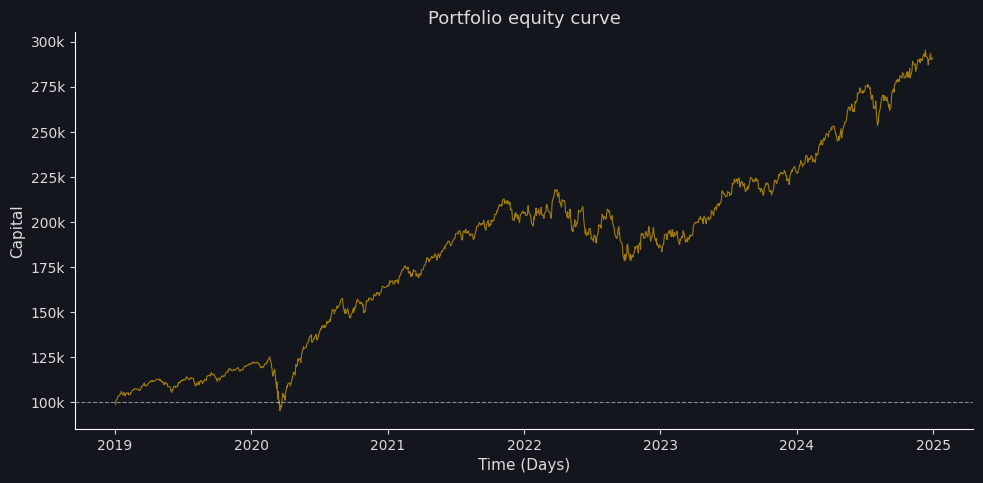

In [103]:
# Defining initial_capital
initial_capital = 100_000

# Cumulative capital over 2019-2024
equity_curve = initial_capital * (1 + portfolio_returns).cumprod()

# Font sizes
plt.rcParams.update({
    "font.size": 11,        # Baseline size
    "axes.titlesize": 13,   # Title size
    "axes.labelsize": 11,   # Axes size
    "xtick.labelsize": 10,  # X-tick size
    "ytick.labelsize": 10   # Y-tick size
})

# Creating subplots
fig, ax = plt.subplots(figsize=(10, 5))

# Customizing layout
background_color = "#13161D"
font_color = "#dbdbdb"
equity_color = "#FFC000"

fig.set_facecolor(background_color)
ax.set_facecolor(background_color)
ax.tick_params(axis="both", which="both", colors=font_color)
ax.spines[["top", "right"]].set_visible(False)

# Equity line
ax.plot(equity_curve.index, equity_curve, color=equity_color, linewidth=0.8, alpha=0.6)

# Initial capital reference
ax.axhline(initial_capital, color=font_color, linestyle="--", linewidth=0.8, alpha=0.6)

# Formatting Y-axis in '100k' format
def thousands_formatter(x, pos):
    sign = "-" if x < 0 else ""
    return f"{sign}{int(abs(x) / 1_000)}k"

ax.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

# Setting labels
ax.set_xlabel("Time (Days)", color=font_color)
ax.set_ylabel("Capital", color=font_color)
ax.set_title("Portfolio equity curve", color=font_color)

# Plotting chart
plt.tight_layout(pad=1.2)
plt.show()